Notebook for running superconductor design experiments (see Table 1).

In [1]:
import numpy as np
from xgboost import XGBRegressor  # using xgboost version 0.90
from sklearn.feature_selection import SelectFromModel

import mbo
import oracles
import util
import searchmodels as sm

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context("notebook");
sns.set_style("darkgrid");

Using TensorFlow backend.


# generate training data

Load ground-truth model and data.

In [2]:
gt = XGBRegressor(**XGB_PARAMS)
gt.load_model("gt_dim60.model")
d = np.load('data_dim60.npz')
X_nxm = d['X_nxm']
gt_n = d['gt_n']

Extract data with ground-truth labels below 80-th percentile to build training distribution

Max label in training data: 138.3. 80-th percentile label: 73.8
Xtrain_nxm shape: (17010, 60). gttrain_n shape: 17010


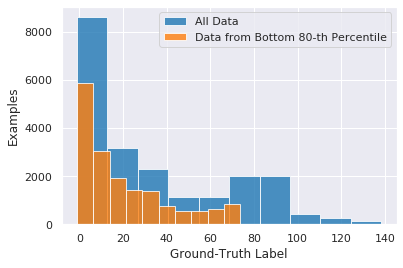

In [3]:
percentile = 80
seed = 0
Xtrain_nxm, gttrain_n, _ = util.get_data_below_percentile(X_nxm, gt_n, percentile, seed=seed)
print("Xtrain_nxm shape: {}. gttrain_n shape: {}".format(Xtrain_nxm.shape, gttrain_n.size))
plt.hist(gt_n, alpha=0.8);
plt.hist(gttrain_n, alpha=0.8);
plt.legend(["All Data", "Data from Bottom {}-th Percentile".format(percentile)]);
plt.xlabel("Ground-Truth Label"); plt.ylabel('Examples');

Fit training distribution and draw example training data

Xo_nxm shape: (17010, 60). gto_n shape: (17010,)


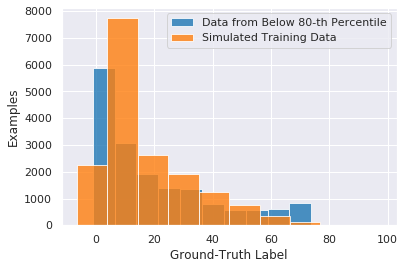

In [4]:
seed = 0
gt_sigma = 1.0
n_train = gttrain_n.size

# fit training distribution
init_searchmodel = sm.MultivariateGaussian(Xtrain_nxm.shape[1])
init_searchmodel.fit(Xtrain_nxm)
mean_d, cov_dxd = init_searchmodel.get_parameters()
# np.savez('init_searchmodel.npz', mean_d=mean_d, cov_dxd=cov_dxd)

# example training data for oracle
Xo_nxm = init_searchmodel.sample(n_train, seed=seed)
gtnno_n = gt.predict(Xo_nxm).flatten()
np.random.seed(seed + 1)
gto_n = gtnno_n + gt_sigma * np.random.randn(gtnno_n.size)

print("Xo_nxm shape: {}. gto_n shape: {}".format(Xo_nxm.shape, gto_n.shape))
plt.hist(gttrain_n, alpha=0.8);
plt.hist(gto_n, alpha=0.8);
plt.legend(['Data from Below {}-th Percentile'.format(percentile), 'Simulated Training Data']);
plt.xlabel("Ground-Truth Label"); plt.ylabel('Examples');

# train initial oracles

Train and save oracles

In [ ]:
n_neuralnets = 3
hidden_units = (100, 100, 100, 100, 10)
input_dim = Xo_nxm.shape[1]
for seed in range(10):
    # get training data
    d = np.load('traindata/traindata_d{}_seed{}.npz'.format(input_dim, seed))
    Xo_nxm = d['Xo_nxm']
    gto_n = d['gto_n']

    # fit and save initial oracle
    oracle = oracles.DeepEnsemble(input_dim=input_dim, n_nn=n_neuralnets, hidden_units=hidden_units)
    oracle.fit(Xo_nxm, gto_n)
    # oracle.save('initial_oracles', prefix="d{}_4-100_seed{}".format(input_dim, seed))

Evaluate example oracle (Figure S2)

In [60]:
oracle = oracles.DeepEnsemble(input_dim=input_dim, n_nn=n_neuralnets, hidden_units=hidden_units)
oracle.load('initial_oracles/', prefix="d{}_4-100_seed1".format(input_dim))
Xtest_nxm = init_searchmodel.sample(100000, seed=0)
gttest_n = gt.predict(Xtest_nxm).flatten()
pred_n, _ = oracle.predict(Xtest_nxm)

Oracle RMSE: 7.3


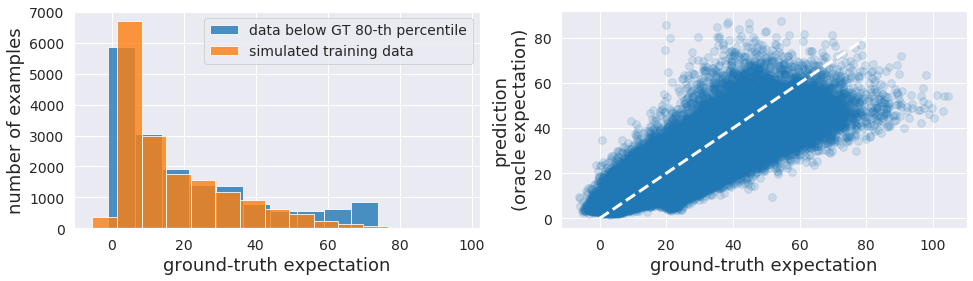

In [63]:
Xo_nxm = init_searchmodel.sample(n_train, seed=1)
gtnno_n = gt.predict(Xo_nxm).flatten()
np.random.seed(2)
gto_n = gtnno_n + gt_sigma * np.random.randn(gtnno_n.size)

plt.figure(figsize=(16, 4));
fs, tick_fs = 18, 14
plt.subplot(121);
plt.hist(gttrain_n, alpha=0.8, label="data below GT {}-th percentile".format(perc));
plt.hist(gto_n, alpha=0.8, bins=15, label="simulated training data");
plt.legend(fontsize=tick_fs); plt.xticks(fontsize=tick_fs); plt.yticks(fontsize=tick_fs);
plt.xlabel("ground-truth expectation", fontsize=fs); plt.ylabel("number of examples", fontsize=fs);

plt.subplot(122);
plt.scatter(gttest_n, pred_n, s=60, alpha=0.15)
plt.plot([0, 80], [0, 80], "--w", linewidth=3); plt.xticks(fontsize=tick_fs); plt.yticks(fontsize=tick_fs);
plt.xlabel("ground-truth expectation", fontsize=fs);
plt.ylabel("prediction\n(oracle expectation)", fontsize=fs);
print("Oracle RMSE: {:.2}".format(util.rmse(gttest_n, pred_n)))

# run design experiments

In [ ]:
n_trials = 10
n_iter = 20 
iw_alpha = 0.2
mbo_hps = [0.9, 0.9, 0.01, 0.9, 0.9, 0.01]
methods = ['cbas', 'dbas', 'rwr', 'fb', 'cem-pi', 'cma-es']
n_neuralnets = 3
hidden_units = (100, 100, 100, 100, 10)
n_train, input_dim = Xtrain_nxm.shape
ground_truth_fn = lambda X_nxm: gt.predict(X_nxm).flatten()

for method, mbo_hp in zip(methods, mbo_hps):
    for seed in range(n_trials):

        # get training data
        d = np.load('traindata/traindata_d{}_seed{}.npz'.format(input_dim, seed))
        Xo_nxm = d['Xo_nxm']
        gto_n = d['gto_n']
        
        # get initial oracle
        oracle = oracles.DeepEnsemble(input_dim=input_dim, n_nn=n_neuralnets, hidden_units=hidden_units)
        oracle.load('initial_oracles/', prefix="d{}_4-100_seed{}".format(input_dim, seed))

        # run MBO
        if method == "cbas":
            designalg = mbo.ConditioningByAdaptiveSampling(mbo_hp)
            designalgaf = mbo.ConditioningByAdaptiveSampling(mbo_hp)
        elif method == "dbas":
            designalg = mbo.DesignByAdaptiveSampling(mbo_hp)
            designalgaf = mbo.DesignByAdaptiveSampling(mbo_hp)
        elif method == "rwr":
            designalg = mbo.RewardWeightedRegression(mbo_hp)
            designalgaf = mbo.RewardWeightedRegression(mbo_hp)
        elif method == "fb":
            designalg = mbo.FeedbackMechanism(Xo_nxm, gto_n, mbo_hp)
            designalgaf = mbo.FeedbackMechanism(Xo_nxm, gto_n, mbo_hp)
        elif method == 'cem-pi':
            max_gt_train = np.max(gto_n)
            designalg = mbo.CrossEntropyMethodWithProbabilityOfImprovement(max_gt_train, mbo_hp)
            designalgaf = mbo.CrossEntropyMethodWithProbabilityOfImprovement(max_gt_train, mbo_hp)
        elif method == 'rand':
            designalg = mbo.RandomSearch(max_gt_train)
            designalgaf = mbo.RandomSearch(max_gt_train)
        elif method == 'cma-es':
            max_gt_train = np.max(gto_n)
            designalg = mbo.CovarianceMatrixAdaptationEvolutionStrategy(
                max_gt_train, sigma=mbo_hp, use_probimp=True)
            designalgaf = mbo.CovarianceMatrixAdaptationEvolutionStrategy(
                max_gt_train, sigma=mbo_hp, use_probimp=True)
            

        traj_noaf = designalg.run(Xo_nxm, gto_n, ground_truth_fn, oracle, init_searchmodel, autofocus=False,
                                  n_iter=n_iter)
        # traj_noaf.save("results/{}_traj_noaf_4-100_seed{}.npz".format(
        #     method, seed))

        traj_af = designalgaf.run(Xo_nxm, gto_n, ground_truth_fn, oracle, init_searchmodel, autofocus=True,
                                  iw_alpha=iw_alpha, n_iter=n_iter)
        # traj_af.save("results/{}_traj_af{}_4-100_seed{}.npz".format(
        #         method, iw_alpha, seed))